In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn import metrics
import seaborn as sns
from scipy.spatial.distance import directed_hausdorff

In [2]:
def hausdorff(u, v):
    return max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

def _dice_score(y_true, y_pred):
    return np.sum(y_pred[y_true==y_pred])*2.0 / (np.sum(y_true) + np.sum(y_pred))

def metrics_from_cfm(y_true, y_pred):
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    preci = tp / (tp + fp)
    f1 = (2 * preci * sens) / (sens + preci)
    return sens, spec, preci, f1

def roc_auc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    return metrics.roc_auc_score(y_true, y_pred)

def pr_auc(y_true, y_pred):
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred, pos_label=1)
    precision = np.fliplr([precision])[0]
    recall = np.fliplr([recall])[0]
    return np.trapz(precision,recall)

In [3]:
def split(values, k=20):
    assert len(values) % k == 0
    stepsize = len(values) // k
    value_list = []
    for i in range(k):
        value_list.append(values[i*stepsize:(i + 1)*stepsize])
    return np.asanyarray(value_list)

In [4]:
def plot_roc_curve(y_true, y_pred, ax, code=''):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    auc_roc = metrics.roc_auc_score(y_true, y_pred)
    ax.plot(fpr, tpr,'-',label='Area Under the PR Curve (AUC = %0.4f)' % auc_roc)
    ax.set_title('ROC curve, loss type =  ' + code)
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.legend(loc="lower right")

In [5]:
def plot_precision_recall(y_true, y_pred, ax, code=''):
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred, pos_label=1)
    precision = np.fliplr([precision])[0]
    recall = np.fliplr([recall])[0]
    AUC_prec_rec = np.trapz(precision,recall)
    ax.plot(recall, precision, '-',label='Area Under the PR Curve (AUC = %0.4f)' % AUC_prec_rec)
    ax.set_title('Precision - Recall curve, loss type = ' + code)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend(loc="lower right")

### Data information
- Training data:
+ Bao gồm **20** ảnh **565 $\times$ 584** được chia thành **190k** patches với kích thước mỗi patch là **48 $\times$ 48**
+ Dùng **10%** số patches cho validation
+ Batch size: **32**
+ Optimizer: **Adam**
+ Learning rate: **1e-5**
+ Early stopping: dừng training nếu validation loss không giảm liên tục sau 20 epoches
+ Các loại loss và số epoch đã train:
    * BCE loss: **206 epochs**
    * DICE loss: **195 epochs**
    * Normalized contour loss: **175 epochs**

In [6]:
mask_path = '../history/AUG23_adam_1e-05_contour/result_images/all_masks.png'
contour_path = '../history/all_predictions.png'
dice_path = '../history/AUG23_adam_1e-05_dice/result_images/all_predictions.png'
bce_path = '../history/AUG23_adam_1e-05_bce/result_images/all_predictions.png'
masks = np.asarray(Image.open(mask_path))
contour_imgs = np.asanyarray(Image.open(contour_path))
dice_imgs = np.asanyarray(Image.open(dice_path))
bce_imgs = np.asanyarray(Image.open(bce_path))

In [7]:
masks = masks / 255
contour_imgs = contour_imgs / 255
dice_imgs = dice_imgs / 255
bce_imgs = bce_imgs / 255

In [8]:
masks = split(masks)
contour_imgs = split(contour_imgs)
dice_imgs = split(dice_imgs)
bce_imgs = split(bce_imgs)

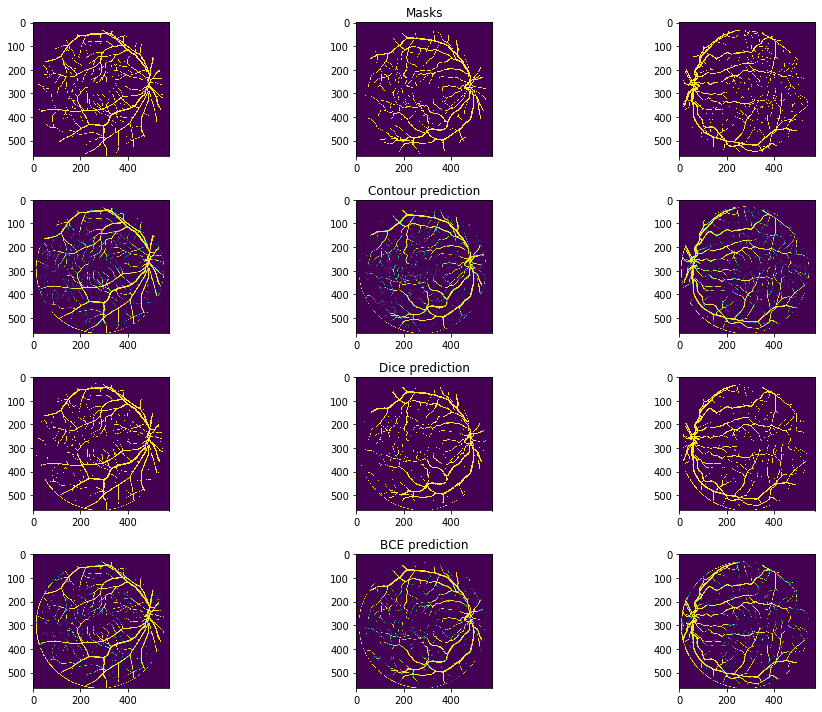

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
axes[0, 0].imshow(masks[0])
axes[0, 1].imshow(masks[1])
axes[0, 2].imshow(masks[5])
axes[0, 1].set_title('Masks')

axes[1, 0].imshow(contour_imgs[0])
axes[1, 1].imshow(contour_imgs[1])
axes[1, 2].imshow(contour_imgs[5])
axes[1, 1].set_title('Contour prediction')

axes[2, 0].imshow(dice_imgs[0])
axes[2, 1].imshow(dice_imgs[1])
axes[2, 2].imshow(dice_imgs[5])
axes[2, 1].set_title('Dice prediction')

axes[3, 0].imshow(bce_imgs[0])
axes[3, 1].imshow(bce_imgs[1])
axes[3, 2].imshow(bce_imgs[5])
axes[3, 1].set_title('BCE prediction')

fig.tight_layout()
plt.show()

### Nhận xét:
- Có một số đốm màu green/blue xuất hiện trong cách ảnh predict: đó là những pixel nằm trong đoạn (0,1)
- Ảnh predict trained bởi contour chi tiết hơn so với dice/bce (HIGH RECALL)
- Ảnh predict trained bởi bce kém chi tiết hơn so với contour/dice
- Ảnh predict trained bởi dice loss có tính quyết định rất cao (có rất ít pixel nằm trong đoạn (0,1) so với 2 hàm loss còn lại)

### AUC-ROC curves

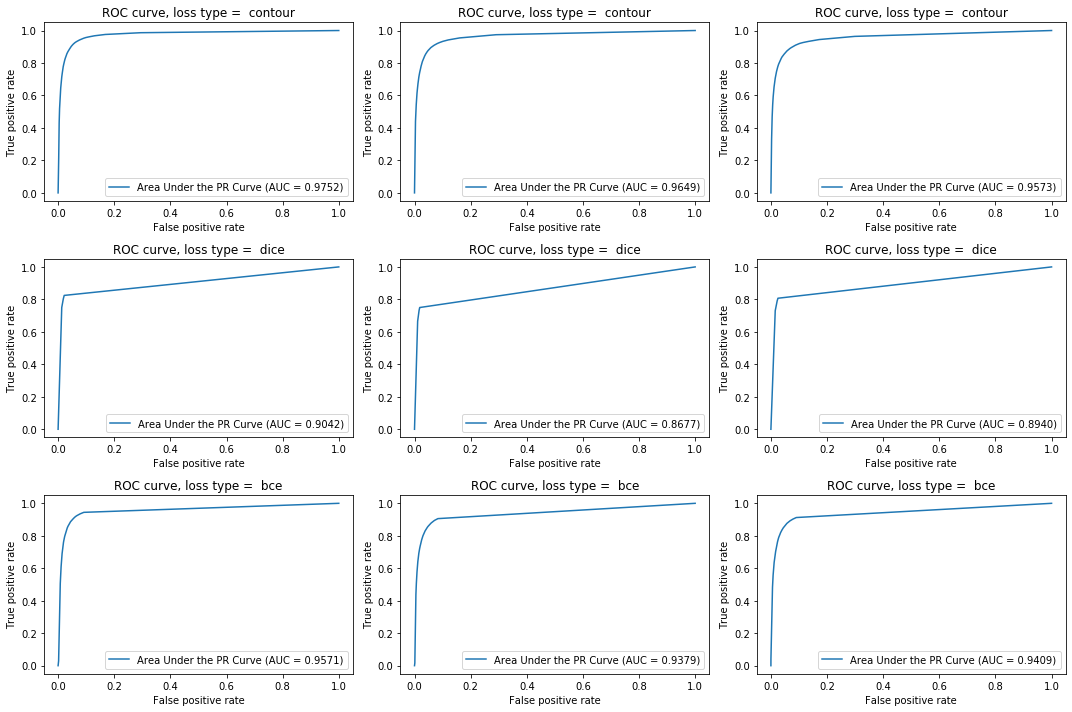

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
plot_roc_curve(masks[0].ravel(), contour_imgs[0].ravel(), axes[0, 0], 'contour')
plot_roc_curve(masks[1].ravel(), contour_imgs[1].ravel(), axes[0, 1], 'contour')
plot_roc_curve(masks[5].ravel(), contour_imgs[5].ravel(), axes[0, 2], 'contour')

plot_roc_curve(masks[0].ravel(), dice_imgs[0].ravel(), axes[1, 0], 'dice')
plot_roc_curve(masks[1].ravel(), dice_imgs[1].ravel(), axes[1, 1], 'dice')
plot_roc_curve(masks[5].ravel(), dice_imgs[5].ravel(), axes[1, 2], 'dice')

plot_roc_curve(masks[0].ravel(), bce_imgs[0].ravel(), axes[2, 0], 'bce')
plot_roc_curve(masks[1].ravel(), bce_imgs[1].ravel(), axes[2, 1], 'bce')
plot_roc_curve(masks[5].ravel(), bce_imgs[5].ravel(), axes[2, 2], 'bce')

fig.tight_layout()
plt.show()

### AUC-Precision-Recall curves

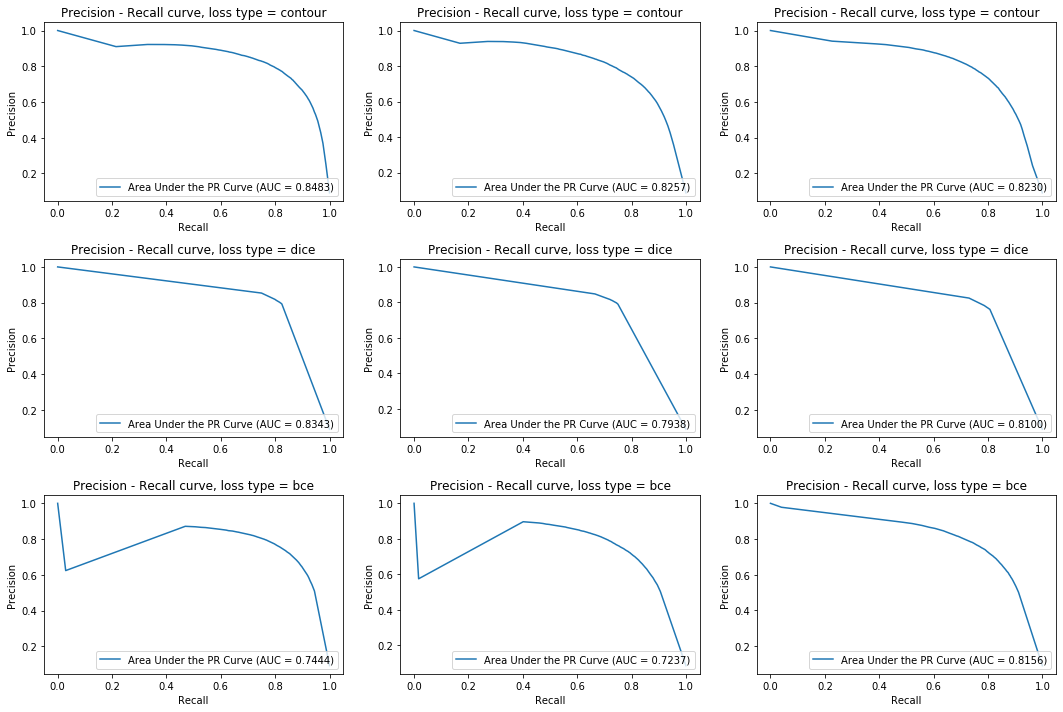

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
plot_precision_recall(masks[0].ravel(), contour_imgs[0].ravel(), axes[0, 0], 'contour')
plot_precision_recall(masks[1].ravel(), contour_imgs[1].ravel(), axes[0, 1], 'contour')
plot_precision_recall(masks[5].ravel(), contour_imgs[5].ravel(), axes[0, 2], 'contour')

plot_precision_recall(masks[0].ravel(), dice_imgs[0].ravel(), axes[1, 0], 'dice')
plot_precision_recall(masks[1].ravel(), dice_imgs[1].ravel(), axes[1, 1], 'dice')
plot_precision_recall(masks[5].ravel(), dice_imgs[5].ravel(), axes[1, 2], 'dice')

plot_precision_recall(masks[0].ravel(), bce_imgs[0].ravel(), axes[2, 0], 'bce')
plot_precision_recall(masks[1].ravel(), bce_imgs[1].ravel(), axes[2, 1], 'bce')
plot_precision_recall(masks[5].ravel(), bce_imgs[5].ravel(), axes[2, 2], 'bce')

fig.tight_layout()
plt.show()

### Prediction probability distribution

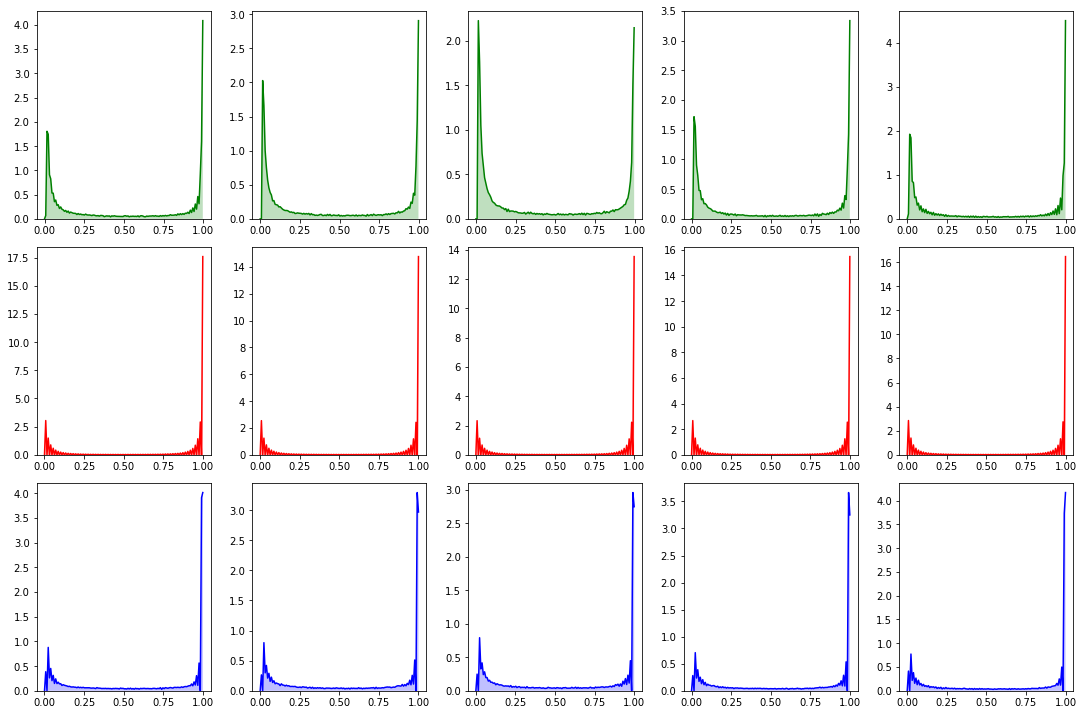

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))
sns.kdeplot(contour_imgs[0].ravel(), shade=True, color='g', ax=axes[0, 0])
sns.kdeplot(contour_imgs[1].ravel(), shade=True, color='g', ax=axes[0, 1])
sns.kdeplot(contour_imgs[10].ravel(), shade=True, color='g', ax=axes[0, 2])
sns.kdeplot(contour_imgs[-2].ravel(), shade=True, color='g', ax=axes[0, 3])
sns.kdeplot(contour_imgs[-1].ravel(), shade=True, color='g', ax=axes[0, 4])

sns.kdeplot(dice_imgs[0].ravel(), shade=True, color='r', ax=axes[1, 0])
sns.kdeplot(dice_imgs[1].ravel(), shade=True, color='r', ax=axes[1, 1])
sns.kdeplot(dice_imgs[10].ravel(), shade=True, color='r', ax=axes[1, 2])
sns.kdeplot(dice_imgs[-2].ravel(), shade=True, color='r', ax=axes[1, 3])
sns.kdeplot(dice_imgs[-1].ravel(), shade=True, color='r', ax=axes[1, 4])

sns.kdeplot(bce_imgs[0].ravel(), shade=True, color='b', ax=axes[2, 0])
sns.kdeplot(bce_imgs[1].ravel(), shade=True, color='b', ax=axes[2, 1])
sns.kdeplot(bce_imgs[10].ravel(), shade=True, color='b', ax=axes[2, 2])
sns.kdeplot(bce_imgs[-2].ravel(), shade=True, color='b', ax=axes[2, 3])
sns.kdeplot(bce_imgs[-1].ravel(), shade=True, color='b', ax=axes[2, 4])

fig.tight_layout()
plt.show()

## Performance evaluation

In [13]:
def apply_func(func, masks, imgs, ravel=True):
    if ravel:
        masks = map(np.ravel, masks)
        imgs = map(np.ravel, imgs)
    return np.asarray([func(mask, img) 
                       for mask, img in zip(masks, imgs)])

def apply_func_multiple(func, masks, imgs, ravel=True):
    return np.asarray([func(mask.ravel(), img.ravel()) 
                        for mask, img in zip(masks, imgs)])

def accuracy(masks, imgs):
    return apply_func(metrics.accuracy_score, masks, imgs)

def _precision_recall_auc(masks, imgs):
    precision, recall, thresholds = metrics.precision_recall_curve(masks, imgs)
    precision = np.fliplr([precision])[0]
    recall = np.fliplr([recall])[0]
    return np.trapz(precision,recall)

def _hausdorff(u, v):
    return max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

def roc_auc(masks, imgs):
    return apply_func(metrics.roc_auc_score, masks, imgs)

def precision_recall_auc(masks, imgs):
    return apply_func(_precision_recall_auc, masks, imgs)

def jaccard(masks, imgs):
    return apply_func(metrics.jaccard_score, masks, imgs)

def dice_score(masks, imgs):
    return apply_func(_dice_score, masks, imgs)

def hausdorff(masks, imgs):
    return apply_func(_hausdorff, masks, imgs, False)

def _cfm_metrics(masks, imgs):
    tn, fp, fn, tp = metrics.confusion_matrix(masks, imgs).ravel()
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    preci = tp / (tp + fp)
    f1 = (2 * preci * sens) / (sens + preci)
    return sens, spec, preci, f1

def _sensitivity(masks, imgs):
    tn, fp, fn, tp = metrics.confusion_matrix(masks, imgs).ravel()
    return tp / (tp + fn)

def _specitivity(masks, imgs):
    tn, fp, fn, tp = metrics.confusion_matrix(masks, imgs).ravel()
    return tn / (tn + fp)

def sensitivity(masks, imgs):
    return apply_func(_sensitivity, masks, imgs)

def specitivity(masks, imgs):
    return apply_func(_specitivity, masks, imgs) 

In [14]:
contour_roc_auc = roc_auc(masks, contour_imgs)
dice_roc_auc = roc_auc(masks, dice_imgs)
bce_roc_auc = roc_auc(masks, bce_imgs)

contour_pr_auc = precision_recall_auc(masks, contour_imgs)
dice_pr_auc = precision_recall_auc(masks, dice_imgs)
bce_pr_auc = precision_recall_auc(masks, bce_imgs)

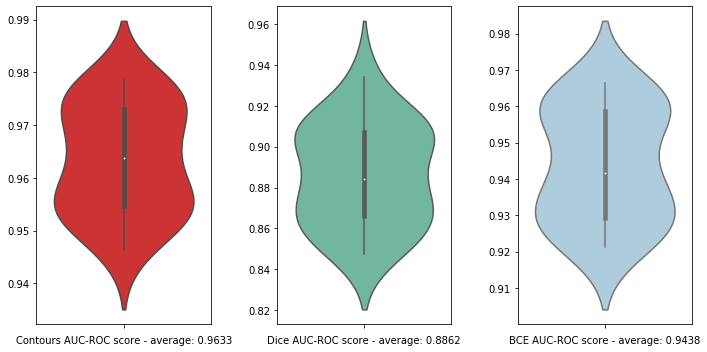

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
sns.violinplot(contour_roc_auc, palette="Set1", orient='v', ax=axes[0])
axes[0].set_xlabel("Contours AUC-ROC score - average: {0:.4f}".format(sum(contour_roc_auc) / len(contour_roc_auc)))

sns.violinplot(dice_roc_auc, palette="Set2", orient='v', ax=axes[1])
axes[1].set_xlabel("Dice AUC-ROC score - average: {0:.4f}".format(sum(dice_roc_auc) / len(dice_roc_auc)))

sns.violinplot(bce_roc_auc, palette="Paired", orient='v', ax=axes[2])
axes[2].set_xlabel("BCE AUC-ROC score - average: {0:.4f}".format(sum(bce_roc_auc) / len(bce_roc_auc)))

fig.tight_layout()
plt.show()

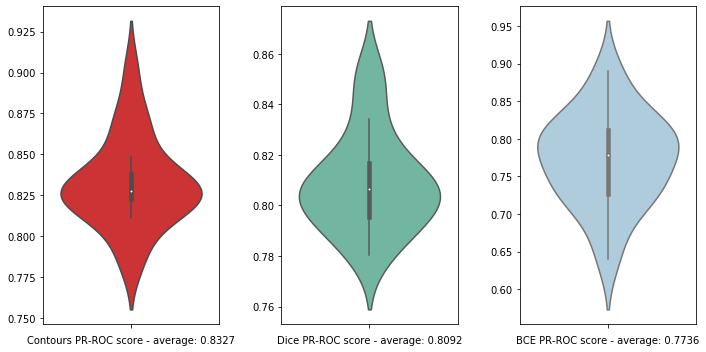

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
sns.violinplot(contour_pr_auc, palette="Set1", orient='v', ax=axes[0])
axes[0].set_xlabel("Contours PR-ROC score - average: {0:.4f}".format(sum(contour_pr_auc) / len(contour_pr_auc)))

sns.violinplot(dice_pr_auc, palette="Set2", orient='v', ax=axes[1])
axes[1].set_xlabel("Dice PR-ROC score - average: {0:.4f}".format(sum(dice_pr_auc) / len(dice_pr_auc)))

sns.violinplot(bce_pr_auc, palette="Paired", orient='v', ax=axes[2])
axes[2].set_xlabel("BCE PR-ROC score - average: {0:.4f}".format(sum(bce_pr_auc) / len(bce_pr_auc)))

fig.tight_layout()
plt.show()

## At cutoff 0.5

In [17]:
cutoff = 0.5
contour_imgs_thres = (contour_imgs >= cutoff).astype('int')
dice_imgs_thres = (dice_imgs >= cutoff).astype('int')
bce_imgs_thres = (bce_imgs >= cutoff).astype('int')

In [18]:
contour_accuracy = accuracy(masks, contour_imgs_thres)
dice_accuracy = accuracy(masks, dice_imgs_thres)
bce_accuracy = accuracy(masks, bce_imgs_thres)

contour_jaccard = jaccard(masks, contour_imgs_thres)
dice_jaccard = jaccard(masks, dice_imgs_thres)
bce_jaccard = jaccard(masks, bce_imgs_thres)

contour_dice = dice_score(masks, contour_imgs_thres)
dice_dice = dice_score(masks, dice_imgs_thres)
bce_dice = dice_score(masks, bce_imgs_thres)

contour_haus = hausdorff(masks, contour_imgs_thres)
dice_haus = hausdorff(masks, dice_imgs_thres)
bce_haus = hausdorff(masks, bce_imgs_thres)

contour_sens = sensitivity(masks, contour_imgs_thres)
dice_sens = sensitivity(masks, dice_imgs_thres)
bce_sens = sensitivity(masks, bce_imgs_thres)

contour_spec = specitivity(masks, contour_imgs_thres)
dice_spec = specitivity(masks, dice_imgs_thres)
bce_spec = specitivity(masks, bce_imgs_thres)

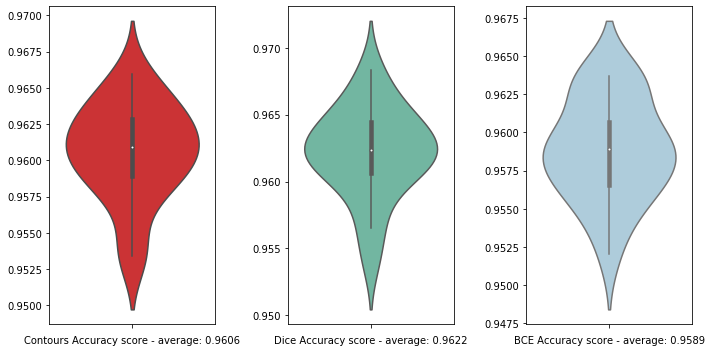

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
sns.violinplot(contour_accuracy, palette="Set1", orient='v', ax=axes[0])
axes[0].set_xlabel("Contours Accuracy score - average: {0:.4f}".format(sum(contour_accuracy) / len(contour_accuracy)))

sns.violinplot(dice_accuracy, palette="Set2", orient='v', ax=axes[1])
axes[1].set_xlabel("Dice Accuracy score - average: {0:.4f}".format(sum(dice_accuracy) / len(dice_accuracy)))

sns.violinplot(bce_accuracy, palette="Paired", orient='v', ax=axes[2])
axes[2].set_xlabel("BCE Accuracy score - average: {0:.4f}".format(sum(bce_accuracy) / len(bce_accuracy)))

fig.tight_layout()
plt.show()

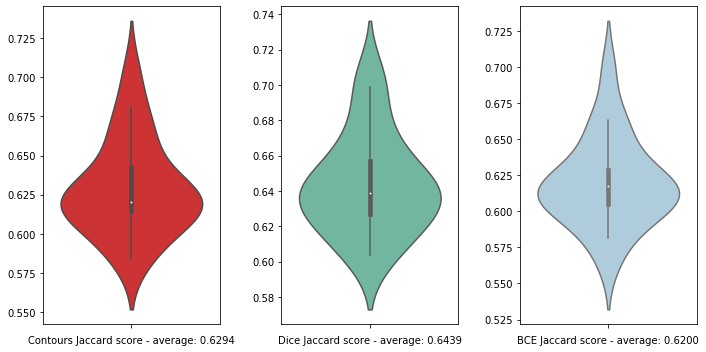

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
sns.violinplot(contour_jaccard, palette="Set1", orient='v', ax=axes[0])
axes[0].set_xlabel("Contours Jaccard score - average: {0:.4f}".format(sum(contour_jaccard) / len(contour_jaccard)))

sns.violinplot(dice_jaccard, palette="Set2", orient='v', ax=axes[1])
axes[1].set_xlabel("Dice Jaccard score - average: {0:.4f}".format(sum(dice_jaccard) / len(dice_jaccard)))

sns.violinplot(bce_jaccard, palette="Paired", orient='v', ax=axes[2])
axes[2].set_xlabel("BCE Jaccard score - average: {0:.4f}".format(sum(bce_jaccard) / len(bce_jaccard)))

fig.tight_layout()
plt.show()

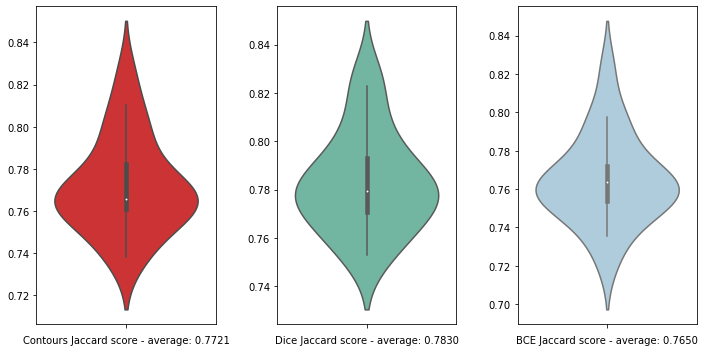

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
sns.violinplot(contour_dice, palette="Set1", orient='v', ax=axes[0])
axes[0].set_xlabel("Contours Jaccard score - average: {0:.4f}".format(sum(contour_dice) / len(contour_dice)))

sns.violinplot(dice_dice, palette="Set2", orient='v', ax=axes[1])
axes[1].set_xlabel("Dice Jaccard score - average: {0:.4f}".format(sum(dice_dice) / len(dice_dice)))

sns.violinplot(bce_dice, palette="Paired", orient='v', ax=axes[2])
axes[2].set_xlabel("BCE Jaccard score - average: {0:.4f}".format(sum(bce_dice) / len(bce_dice)))

fig.tight_layout()
plt.show()

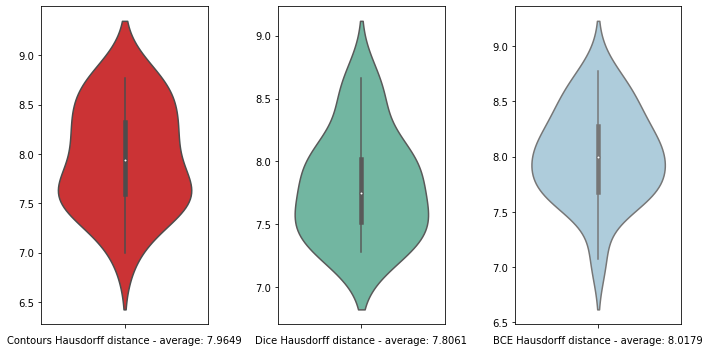

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

sns.violinplot(contour_haus, palette="Set1", orient='v', ax=axes[0])
axes[0].set_xlabel("Contours Hausdorff distance - average: {0:.4f}"\
                   .format(sum(contour_haus) / len(contour_haus)))

sns.violinplot(dice_haus, palette="Set2", orient='v', ax=axes[1])
axes[1].set_xlabel("Dice Hausdorff distance - average: {0:.4f}"\
                   .format(sum(dice_haus) / len(dice_haus)))

sns.violinplot(bce_haus, palette="Paired", orient='v', ax=axes[2])
axes[2].set_xlabel("BCE Hausdorff distance - average: {0:.4f}"\
                   .format(sum(bce_haus) / len(bce_haus)))

fig.tight_layout()
plt.show()

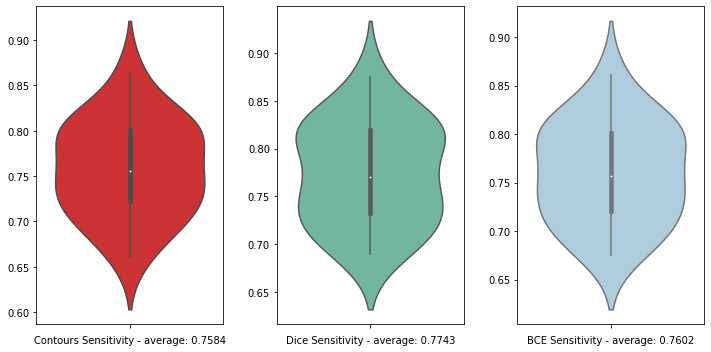

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

sns.violinplot(contour_sens, palette="Set1", orient='v', ax=axes[0])
axes[0].set_xlabel("Contours Sensitivity - average: {0:.4f}"\
                   .format(sum(contour_sens) / len(contour_sens)))

sns.violinplot(dice_sens, palette="Set2", orient='v', ax=axes[1])
axes[1].set_xlabel("Dice Sensitivity - average: {0:.4f}"\
                   .format(sum(dice_sens) / len(dice_sens)))

sns.violinplot(bce_sens, palette="Paired", orient='v', ax=axes[2])
axes[2].set_xlabel("BCE Sensitivity - average: {0:.4f}"\
                   .format(sum(bce_sens) / len(bce_sens)))

fig.tight_layout()
plt.show()

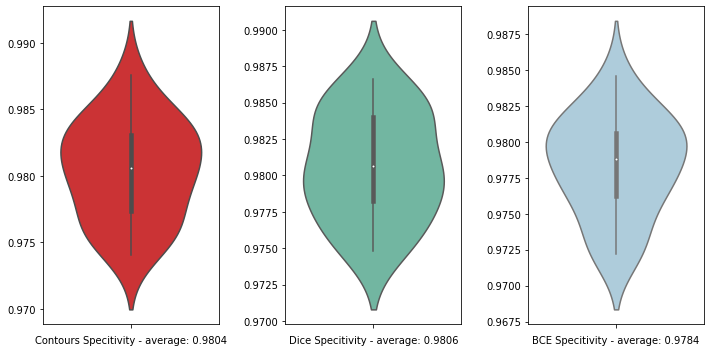

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

sns.violinplot(contour_spec, palette="Set1", orient='v', ax=axes[0])
axes[0].set_xlabel("Contours Specitivity - average: {0:.4f}"\
                   .format(sum(contour_spec) / len(contour_spec)))

sns.violinplot(dice_spec, palette="Set2", orient='v', ax=axes[1])
axes[1].set_xlabel("Dice Specitivity - average: {0:.4f}"\
                   .format(sum(dice_spec) / len(dice_spec)))

sns.violinplot(bce_spec, palette="Paired", orient='v', ax=axes[2])
axes[2].set_xlabel("BCE Specitivity - average: {0:.4f}"\
                   .format(sum(bce_spec) / len(bce_spec)))

fig.tight_layout()
plt.show()